In [ ]:
# Copyright (C) 2019  Communication Network Security Laboratory, SSU, Seoul

# This program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 2 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# Integration Code

In order to check the output of each approaches (DEX, Manifest, Assets) as well as integrated results, we first choose the list of trained & tested datasets (501 Normal & 501 Packer) that generated from under-sampling method in DEX analysis. With those datasets, we also applied to Assets and Manifest to get the output.   

In [1]:
import os
import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

BASE_DIR="dataset/kaggle/"

Model for ByteCode

In [2]:
class Bytecode_FeatureModel(object):
    """Model for classification."""

    def __init__(self):
        """Init."""
        from sklearn.feature_extraction.text import CountVectorizer
        from sklearn.feature_extraction.text import TfidfTransformer

        self.count_vect = CountVectorizer()
        self.tfidf_transformer = TfidfTransformer()
        config = configparser.ConfigParser()
        config.read("config")
        self.bytecode_dir = config.get("Data", "Bytecode")

    def train_knn(self, X_train, y_train, X_test, neighbors=4):
        from sklearn.neighbors import KNeighborsClassifier
        knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=neighbors, p=2,
           weights='uniform')
        # knn_model = KNeighborsClassifier(n_neighbors=neighbors)
        knn_model.fit(X_train, y_train)
        y_predicted = knn_model.predict(X_test)
        return y_predicted
    
    def train_svm(self, X_train, y_train, X_test, g='scale'):
        from sklearn import svm
        clf = svm.SVC(gamma=g)
        clf.fit(X, y)
        y_predicted = clf.predict(X_test)
        return y_predicted
                
    def train_naiveBayes(self, features, labels, test_v):
        """Train with naiveBayes."""
        from sklearn.model_selection import train_test_split
        from sklearn.naive_bayes import MultinomialNB
        X_train, X_test, y_train, y_test = train_test_split(features,
                                                            labels,
                                                            random_state=8586)
        X_train_counts = self.count_vect.fit_transform(X_train)
        X_train_tfidf = self.tfidf_transformer.fit_transform(X_train_counts)
        self.clf = MultinomialNB().fit(X_train_tfidf, y_train)
        return self.clf.predict(self.count_vect.transform([test_v]))
    
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

# STEP 1: Get Dataframe of Bytecode (MAIN DATASET) 

--- THE FOLLOWING STEPS HAVE BEEN RUN AND OUTPUT DATASET AS PICKLE 

TURN THE CODE SECTION INTO CODE IF YOU WANT TO RUN THE PROCESS AGAIN

In [3]:
### CODE - GET BYTECODE DATASET
config = configparser.ConfigParser()
config.read("config")
bytecode_dir = config.get("Data", "Bytecode") 
total_dir = config.get("Data", "Total") 

all_df = pd.DataFrame()
for f in os.listdir(bytecode_dir):
    if all(x in f for x in ['df_packer']):
        df = pd.read_json(os.path.join(bytecode_dir, f))
        all_df = all_df.append(df)
for f in os.listdir(total_dir):
    if all(x in f for x in ['W64', 'uvs']):
        df = pd.read_json(os.path.join(total_dir, f))
        all_df = all_df.append(df)

packer_df = all_df[all_df['packer'] != "Normal"]
normal_df = all_df[all_df['packer'] == "Normal"]

### CODE - CHECK PACKER PLOT
ax = sns.countplot(y="packer", data=packer_df)

Normal (0): 15749
Packer (1): 501
Proportion: 31.44 : 1


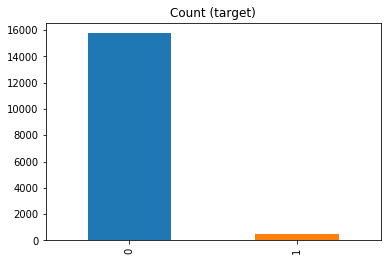

In [4]:
### CODE - FOR TRANSFORMING THE DATASET 
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing

def lamda_func(x):
    output = np.zeros(11, dtype=int)
    for i in x:
        test = np.sum([output[i], 1], dtype=int)
        output[i] = test
    return output

def packerization(x):
    if x != "Normal":
        return "Packer"
    return x

#### Packerlization and Under-sampling

lb = preprocessing.LabelEncoder()
all_df['packer_label'] = all_df['packer']
all_df['packer_label'] = all_df['packer_label'].apply(packerization)
all_df['packer_label'] = lb.fit_transform(all_df['packer_label'])
all_df['binned'] = all_df['feature'].apply(lamda_func)

##### Create X, y
X = all_df['binned']
y = all_df['packer_label']
X = np.array(list(X), dtype=np.int)
y = np.array(list(y), dtype=np.int)

target_count = all_df.packer_label.value_counts()
print('Normal (0):', target_count[0])
print('Packer (1):', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');
plt.savefig(os.path.join(BASE_DIR, 'bytecode_before_undersampling.pdf'))

Random under-sampling:
0    501
1    501
Name: packer_label, dtype: int64


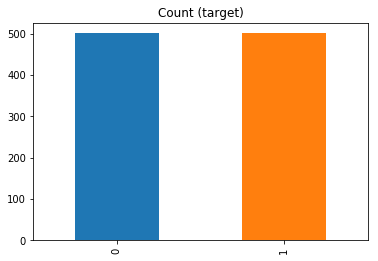

In [5]:
### CODE - Random under-sampling
count_class_0, count_class_1 = all_df.packer_label.value_counts()

df_class_0 = all_df[all_df['packer_label'] == 0]
df_class_1 = all_df[all_df['packer_label'] == 1]

df_class_0_under = df_class_0.sample(count_class_1, random_state=8686)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.packer_label.value_counts(sort=False))

df_test_under.packer_label.value_counts(sort=False).plot(kind='bar', title='Count (target)');
plt.savefig(os.path.join(BASE_DIR, 'bytecode_after_undersampling.pdf'))

count_packer = 0
count_normal = 0
saved_packer_df = df_test_under[df_test_under['packer_label'] != 0]
saved_normal_df = df_test_under[df_test_under['packer_label'] != 1]
for app in df_class_0['md5'].unique():
    count_packer += 1
for app in df_class_1['md5'].unique():
    count_normal += 1

# CALCULATION: Split The Sample And Store Into Files

This step allows us to get the data without going through the previous steps. 

##### Note: 
Although number of dataset are same (501/501). The number of app can not be the same. (468/499).
Since the sampling method are based on whole dataset which contains duplicated md5 hashes (more than one DEX in one file). We tried to extract the md5 and tried to under-sampling the normal dataset, however that method resulted in lost of information. 

# DEBUG ONLY

###### Create X, y data
#def test_split(df_test_under, rt=8585):
    X = df_test_under['binned'] 
    y = df_test_under['packer_label']
    X = np.array(list(X), dtype=np.int)
    y = np.array(list(y), dtype=np.int)
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.4,random_state=rt)
    return X_train, X_test, y_train, y_test

BASE_DIR="dataset/kaggle/"

###### Please ensure this file exists, or else please uncomment the above CODE section and run again
INTEGRATED_FILE = os.path.join(BASE_DIR,"integrated_df.pickle") 
integrated_df = pd.read_pickle(INTEGRATED_FILE)
saved_packer_df = integrated_df[integrated_df['packer_label'] != 0]
saved_normal_df = integrated_df[integrated_df['packer_label'] != 1]

count_packer = 0
count_normal = 0
for app in saved_packer_df['md5'].unique():
    count_packer += 1
for app in saved_normal_df['md5'].unique():
    count_normal += 1

print("Total Num of Packer App: %d" % count_packer)
print("Total Num of Normal App: %d" % count_normal)

# GET TRAIN

Ensure that the md5 of packer apps exists on all approaches and provides training set with test size 0.4 based on md5 list. 

# CODE - CHECK PACKER

#### CHECK Common md5 from both assets packer, DEX, and Manifest packer
ASSETS_DIR = "dataset/kaggle/assets/"

SPLITTED_PACKER_FILE = os.path.join(BASE_DIR,"splited_packer_df.pickle")
train.to_pickle(SPLITTED_PACKER_FILE)

MANIFEST_FILE = os.path.join(BASE_DIR,"manifest/total_manifest.json")
final_manifest_df = pd.read_json(MANIFEST_FILE)
final_packer_assets = os.path.join(ASSETS_DIR, "final_packer_df_24012019.pickle")
final_packer_df = pd.read_pickle(final_packer_assets)
md5_check = np.intersect1d(saved_packer_df['md5'].unique(), final_packer_df['app_md5'].unique()).tolist()
md5_train_final = np.intersect1d(md5_check, final_manifest_df['md5'].unique()).tolist()

# CODE - THIS CODE IS FOR SPLITING OF PACKER MD5. 

### It is used for other approaches

train_df = pd.DataFrame()
##### PRINT MD5 FOR TRAIN
for md5 in md5_train_final:
    train_df = train_df.append(saved_packer_df[saved_packer_df['md5'] == md5], ignore_index=True)

##### MAKE A DATASET WITH PACKER INFORMATION ONLY, AND SPLIT INTO TRAIN AND TEST
for_split_df = train_df[['md5','packer']]
train, test = train_test_split(for_split_df,
                               test_size=0.4,random_state=8586)

##### Save For Other Approaches To Use
train.to_pickle(os.path.join(BASE_DIR, "train_packer_md5.pickle"))
test.to_pickle(os.path.join(BASE_DIR, "test_packer_md5.pickle"))

#### Collect Train&Test Packer Dataset

In [6]:
train = pd.DataFrame()
test = pd.DataFrame()

if os.path.isfile(os.path.join(BASE_DIR, "train_packer_md5.pickle")):
    train = pd.read_pickle(os.path.join(BASE_DIR, "train_packer_md5.pickle"))
if os.path.isfile(os.path.join(BASE_DIR, "test_packer_md5.pickle")):
    test = pd.read_pickle(os.path.join(BASE_DIR, "test_packer_md5.pickle"))
print("Packer Train: %d" % len(train.md5.unique()))
print("Packer Test: %d" % len(test.index))

INTEGRATED_FILE = os.path.join(BASE_DIR,"integrated_df.pickle") 
integrated_df = pd.read_pickle(INTEGRATED_FILE)

merged_train_df = pd.merge(integrated_df, train, how='inner', on=['md5']) # Merged to final train set
merged_test_df = pd.merge(integrated_df, test, how='inner', on=['md5']) # Merged to final test set

Packer Train: 286
Packer Test: 201


#### Collect normal dataset

In [7]:
saved_normal_df = integrated_df[integrated_df['packer_label'] != 1]

train_normal, test_normal = train_test_split(saved_normal_df,
                               test_size=0.4,random_state=8586)

print("Normal train: %d" % len(train_normal.index))
print("Normal test: %d" % len(test_normal.index))

Normal train: 300
Normal test: 201


In [8]:
#### Merge normal and packer for SVM train
input_train = merged_train_df.append(train_normal)
input_test = merged_test_df.append(test_normal)

## Turn into SVM Input

In [9]:
def makeSVM(df):
    X = df['binned'] 
    y = df['packer_label']
    X = np.array(list(X), dtype=np.int)
    y = np.array(list(y), dtype=np.int)
    return X, y

X_train, y_train = makeSVM(input_train)
X_test, y_test = makeSVM(input_test)
X = np.concatenate((X_train,X_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)

## DEX Analysis: Implementation on SVM Classification Prediction

#### CHECK WITH GAMMA = 'scale'

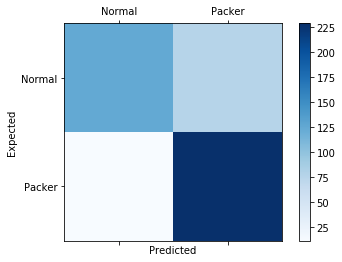

              precision    recall  f1-score   support

      Normal       0.92      0.62      0.74       201
      Packer       0.75      0.95      0.84       240

   micro avg       0.80      0.80      0.80       441
   macro avg       0.83      0.79      0.79       441
weighted avg       0.83      0.80      0.80       441



In [10]:
def check_average_recall(X_train, X_test, y_train, y_test, gamma="scale"):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    feature_model = Bytecode_FeatureModel()
    y_pred = feature_model.train_svm(X_train, y_train, X_test, gamma)
    conf_mat = confusion_matrix(y_test,y_pred)

    labels = ['Normal', 'Packer']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    #plt.savefig(os.path.join(BASE_DIR, 'bytecode_matrix.pdf'))
    print(classification_report(y_test, y_pred, target_names=['Normal','Packer']))
    return y_pred

y_pred = check_average_recall(X_train, X_test, y_train, y_test)

Cross-Tab

In [11]:
# Change label back
pd.crosstab(lb.inverse_transform(y_test), lb.inverse_transform(y_pred), 
            rownames=['Expected'], colnames=['Predicted'], margins=True)

Predicted,Normal,Packer,All
Expected,,,
Normal,125,76,201
Packer,11,229,240
All,136,305,441


In [12]:
# Check with GridSearch CV
from sklearn.model_selection import GridSearchCV
from sklearn import svm
#In case of classifier like knn the parameter to be tuned is n_neighbors
parameters = {'C':[1, 10], 'gamma':["scale", "auto"]}
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    svc = svm.SVC(kernel="rbf")
    clf = GridSearchCV(svc, parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X, y)
    print("Best param: %s" % clf.best_params_)


# Tuning hyper-parameters for precision

Best param: {'gamma': 'auto', 'C': 1}
# Tuning hyper-parameters for recall

Best param: {'gamma': 'auto', 'C': 1}


#### CHECK WITH GAMMA = 'auto'

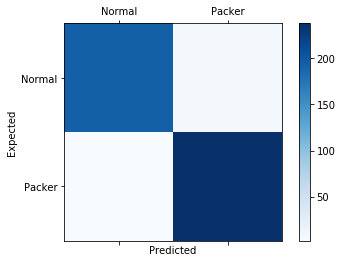

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       201
      Packer       0.97      0.99      0.98       240

   micro avg       0.98      0.98      0.98       441
   macro avg       0.98      0.98      0.98       441
weighted avg       0.98      0.98      0.98       441



In [13]:
y_pred = check_average_recall(X_train, X_test, y_train, y_test, "auto")

In [14]:
pd.crosstab(lb.inverse_transform(y_test), lb.inverse_transform(y_pred), 
            rownames=['Expected'], colnames=['Predict'], margins=True)

Predict,Normal,Packer,All
Expected,,,
Normal,194,7,201
Packer,2,238,240
All,196,245,441


## Separate Test For DEX 

For finding the misjudged md5 (Using "auto" gamma of SVM)

In [15]:
import json
dex_output = {}
PREDICTION_DIR = os.path.join(BASE_DIR, "predictions")
if os.path.isfile(os.path.join(PREDICTION_DIR, "dex_predictions")):
    with open(os.path.join(PREDICTION_DIR, "dex_predictions")) as data_file:    
        dex_output = json.load(data_file)
else:    
    # CHECK WITH gamma = auto
    def predict(X_train, X_test, y_train, y_test, gamma="auto"):
        from sklearn.metrics import classification_report
        from sklearn.metrics import confusion_matrix

        feature_model = Bytecode_FeatureModel()
        y_pred = feature_model.train_svm(X_train, y_train, X_test, gamma)
        return y_pred

    md5_test = input_test.md5.unique()
    for md5 in md5_test:
        test_app_df = input_test[input_test.md5 == md5]
        X_app, y_app = makeSVM(test_app_df)
        out = predict(X_train, X_app, y_train, y_app, gamma="auto")
        if out[0] != y_app[0]:
            print("Predicted: %s" %  out[0])
            print("Expected: %s" % y_app[0])
            print("Md5: %s" % md5)
            dex_output[md5]  = "%s:%s" % (out[0], y_app[0]) # Predict, expected
    # Output results
    with open(os.path.join(PREDICTION_DIR, "dex_predictions"), 'w') as fp:
        json.dump(dex_output, fp)
        
print(dex_output)

{'85cdb59a8a0028441cf4d59cf94a5a67': '1:0', '80be76c7fbe7cbf1f7c24b9d4823bac2': '1:0', '1a3b2f1bb2c12e484c9dc62742400065': '1:0', '3532c52aebd9fed430c181f1f191b4fd': '1:0', '3ac485e4096b4d1cb00791feb45b0fec': '1:0', '91eb36a0bfe2684eaa4671144eeee7ab': '1:0', 'de94239804f274e1cc07b7a147f0b98b': '0:1', '27541cea57b531e418dc7d8ad4a0b077': '1:0', '06e5793bddbfb4858f7b0f0a3871cc06': '0:1'}


# DEX CLASSIFICATION

Collect normal dataset md5

In [16]:
normal_test_md5 = test_normal[['md5','packer']]
test_packer_md5 = merged_test_df[['md5', 'packer_x']]
md5_list_packer = test_packer_md5.md5.unique()
md5_list_normal = normal_test_md5.md5.unique()
# Store md5_list_normal
with open(os.path.join(BASE_DIR, "md5_list_normal_integrated.pickle"), 'w') as fp:
        json.dump(list(md5_list_normal), fp)

# MANIFEST CLASSIFICATION 

Getting output from manifest classification

In [17]:
#PREDICT_NORMAL_FILE = os.path.join(MANIFEST_DIR, "predict_normal_integrated_output.pickle") # all
#PREDICT_NORMAL_FILE_TN = os.path.join(MANIFEST_DIR, "predict_normal_tn_integrated_output.pickle") # True Negative
#if os.path.isfile(PREDICT_NORMAL_FILE):
#    with open(PREDICT_NORMAL_FILE, "rb") as f:
#        predicted_manifest_df = pd.read_pickle(f)
MANIFEST_DIR = os.path.join(BASE_DIR, "manifest")
predicted_man = pd.DataFrame()
if os.path.isfile(os.path.join(MANIFEST_DIR, "predict_integrated_output.pickle")):
    predicted_man = pd.read_pickle(os.path.join(MANIFEST_DIR, "predict_integrated_output.pickle"))
manifest_out = predicted_man.md5.unique()


# ASSETS CLASSIFICATIONS

In [18]:
ASSETS_DIR = os.path.join(BASE_DIR, "assets")
PACKER_TEST_ASSETS_DF = os.path.join(ASSETS_DIR, "packer_test_df_output_27012019_v5.pickle")
predicted_assets = pd.DataFrame()
if os.path.isfile(PACKER_TEST_ASSETS_DF):
    with open(PACKER_TEST_ASSETS_DF, "rb") as fd:
        predicted_assets = pd.read_pickle(fd)

md5_list_assets = predicted_assets.app_md5.unique()
md5_list_assets_dex = set(md5_list_assets).intersection(md5_list_packer)
wrong_assets_predict = predicted_assets[predicted_assets['predict'] != predicted_assets['tested']]
correct_assets_predict = predicted_assets[~predicted_assets.app_md5.isin(wrong_assets_predict.app_md5)]
assets_out =correct_assets_predict.app_md5.unique()

# APKID CLASSIFICATIONS

In [19]:
# APKID TEST
def _exec(cmd, silent=False):
    """Execute shell"""
    import subprocess  
    channel = open(os.devnull, 'wb') if silent is True else subprocess.PIPE
    p = subprocess.Popen(cmd, stdout=channel, stderr=channel, shell=True)
    out, err = p.communicate()
    if err:
        print(err)
    return out.decode("utf-8").strip()

STORE_APKID_PATH = os.path.join(BASE_DIR, "predictions")
STORED_APKID_PACKER = os.path.join(STORE_APKID_PATH, "apkid_out")
packers_mapping = {}
if os.path.isfile(STORED_APKID_PACKER):
    with open(STORED_APKID_PACKER,"r") as fd:
        packers_mapping = json.load(fd)
else:
    PACKER_DIR = "bypass_apkid"
    packers_list = os.listdir(PACKER_DIR)
    for md5 in md5_list_packer:
        matching = [s for s in packers_list if md5 in s]
        if len(matching) > 0:
            cmd = "apkid %s | grep \"> packer\" | wc -l" % os.path.join(PACKER_DIR, matching[0])
            out = _exec(cmd).strip()
            packers_mapping[md5] = out

In [20]:
# Store packers_mapping
#with open(STORED_APKID_PACKER, "w") as fd:
#    json.dump(packers_mapping, fd)

# MAKE A RESULTS TABLE FOR PACKER </br>
Look like this

|  MD5  |   DEX   |   MANIFEST   |   ASSETS  |  INTEGRATED | APKID  | </br>

| ABCDE  |    0.97    |       90.30      |     95.89     |  (0.97+90.30+95.89)/3  |  1    | </br>


In [21]:
integration_results = pd.DataFrame(columns=['md5', 'dex', 'manifest', 'assets', 'integrated', 'apkid'])
for md5 in md5_list_packer:
    # if the md5 is in dex_output, then it is the false positive case
    test_dex = 0
    test_man = 0 
    test_asset = 0     
    test_dex2 = 0 ## Python3 has some problem with division, dont' know why
    test_man2 = 0
    test_asset2 = 0
    test_apkid = 1
    test_integrated = 0
    if md5 not in dex_output:
        test_dex = 0.97  # Calculate in above section
        test_dex2 = 0.97/3
    if md5 in assets_out:
        test_asset = 0.96
        test_asset2 = 0.96/3
    if md5 in manifest_out:
        test_man =  0.90
        test_man2 = 0.90/3
    if md5 in packers_mapping:
        test_apkid = packers_mapping[md5]
    test_integrated = test_dex2 + test_asset2 + test_man2
    row = {'md5':md5, 
           'dex':test_dex, 
           'manifest':test_man,
           'assets':test_asset, 
           'integrated': test_integrated, 
           'apkid': test_apkid}
    integration_results = integration_results.append(row, ignore_index=True)
bypass_apkid_df = integration_results[integration_results['apkid'] == '0']

print(integration_results[integration_results['manifest'] > 0])

                                  md5   dex  manifest  assets  integrated  \
0    b465661fbae48cdabdf04374a6dfc36e  0.97       0.9    0.96    0.943333   
1    818582bee441ffb7c8e1e536f628b343  0.97       0.9    0.96    0.943333   
2    c9802a53a8c6fdf2b699f4c3313676f2  0.97       0.9    0.96    0.943333   
3    9eca79138156355bb66d7b4e195e9f01  0.97       0.9    0.96    0.943333   
4    8c29773135f3008ac3b5e3dd10353524  0.97       0.9    0.96    0.943333   
5    5ee36d4b4c2674302d4df4622d5ddf99  0.97       0.9    0.96    0.943333   
6    1effd6feadd1691ca2e2a8310d03aba0  0.97       0.9    0.96    0.943333   
7    04717bd65e06dab0749b011afae55efa  0.97       0.9    0.96    0.943333   
8    3ae61470ae9cd5f285a477ad90e1bf6a  0.97       0.9    0.96    0.943333   
9    a46236cfac91a9da879a40c0ecadade9  0.97       0.9    0.96    0.943333   
10   5d7dc7f097258c2b4cf1096944f93286  0.97       0.9    0.96    0.943333   
11   119bf9ad791901a1d898b2ba05133c57  0.97       0.9    0.96    0.943333   

### GET THRESHOLD RESULT  = MIN VALUE OF INTEGRATED

In [22]:
packer_threashold = integration_results[integration_results['integrated'].ge(integration_results['integrated'].min())]
print("Threshold: %s" % integration_results['integrated'].min())

Threshold: 0.62


#### TEST WITH BYPASS  APKID

In [23]:
BYPASS_FOLDER = "bypass_apkid"
apkid_detect = {}
for md5 in integration_results.md5.unique():
    f = os.path.join(BYPASS_FOLDER, "%s.apk" % md5)
    cmd = "apkid %s | grep \"> packer\" | wc -l" % f
    out = _exec(cmd)
    apkid_detect[md5] = out
    
print(apkid_detect)
        

{'110fb47546799790ea75a415b52cf433': '0', 'b31bf005ae801ba34c411674e98ad453': '0', 'caf4d41314854f1a22d897a82c73d3ff': '0', '88886e7eb25755e698ba4ff2d00b5fa7': '0', 'cd015c91c62cec19b5ee2d62144dbff8': '0', '003fd8b8ac0ccd26b4fa17f9a8f0fc78': '0', '4474382ebe9fbab8c7a61e558873be8f': '0', 'e3491a6bfdfd95d8324a4a918b847030': '0', '3ae61470ae9cd5f285a477ad90e1bf6a': '0', '6bfa76588cd9c6004f40a34c0fb6a44c': '1', '015515101a49f49a553f072b177ef8fd': '0', '278e1a48299ee929a98711ad8bd7ee53': '0', 'fdd2c6d20f92f89802803f623f1b501b': '0', '8c29773135f3008ac3b5e3dd10353524': '1', 'da2326cdd7c2b30ccb53d96624241bbc': '0', '74b8b38d224a7dfc626fa649b564f9be': '0', '0037f9462eff71b24f471fac0ca362f1': '0', '6e4976478d73f56eaeb024a427f98962': '0', '6cde0ad155ead2f525b807447012863f': '0', '9413a450ea47931103e184ccff3621e9': '0', '49348fdd228ec9b0596fa16897f6c8be': '0', '245025aa18d555ce38181a4e65b0078d': '0', '65b0e4a67aa9d6e8db88d4634497547c': '0', '55592a9beaa6ddd23e00f74257fdf35c': '0', 'aeb479ec285722

In [24]:
count_detect = 0
for md5, value in apkid_detect.items():
    if int(value) > 0:
        count_detect += 1
print("Detected: %d/%d" % (count_detect, len(apkid_detect)))

Detected: 19/196


# MAKE A RESULTS TABLE FOR NORMAL

Count normal test with manifest 

In [25]:
PREDICT_NORMAL_FILE = os.path.join(MANIFEST_DIR, "predict_normal_integrated_output.pickle") # all
PREDICT_NORMAL_FILE_TN = os.path.join(MANIFEST_DIR, "predict_normal_tn_integrated_output.pickle") # True Negative
if os.path.isfile(PREDICT_NORMAL_FILE):
    with open(PREDICT_NORMAL_FILE, "rb") as f:
        man_normal_df = pd.read_pickle(f)

print(len(md5_list_normal))
man_out_n = {}
for n_md5 in md5_list_normal:
    test_n = man_normal_df[man_normal_df['md5'] == n_md5]
    man_out_n[n_md5] = 1 if test_n['predict'].item() != None else 0

201


Count normal test with asset

In [26]:
ASSETS_NORMAL_TEST_DF = os.path.join(ASSETS_DIR, "normal_test_df_output_27012019_v5.pickle")
if os.path.isfile(ASSETS_NORMAL_TEST_DF):
    with open(ASSETS_NORMAL_TEST_DF, "rb") as fd:
        assets_normal_df = pd.read_pickle(fd)
        
ass_out_n = {}
for n_md5 in md5_list_normal:
    test_n = assets_normal_df[assets_normal_df['app_md5'] == n_md5]
    if test_n.empty:
        ass_out_n[n_md5] = 0 # Not assets available
    else:
        ass_out_n[n_md5] = 1 if test_n['predict'].item() != None else 0
    
print(len(ass_out_n))

201


Draw Normal Table, same with packer (only without APKiD)

In [27]:
integration_n_results = pd.DataFrame(columns=['md5', 'dex', 'manifest', 'assets', 'integrated'])
for n_md5 in md5_list_normal:
    # if the md5 is in dex_output, then it is the false positive case
    test_ndex = 0
    test_ndex2 = 0 ## Python3 has some problem with division, dont' know why
    test_nman = 0 
    test_nman2 = 0
    test_nasset = 0 
    test_nasset2 = 0
    test_nintegrated = 0
    if n_md5 not in dex_output:
        test_ndex = 0.99  # Calculate in above section
        test_ndex2 = 0.99/3
    if n_md5 in ass_out_n:
        if ass_out_n[n_md5] == 1:
            test_nasset = 0.97
            test_nasset2 = 0.97/3
    if n_md5 in man_out_n:
        if man_out_n[n_md5] == 1:
            test_nman =  0.976
            test_nman2 = 0.976/3
    test_nintegrated = test_ndex2 + test_nman2 + test_nasset2
    row = {'md5':n_md5, 
           'dex':test_ndex, 
           'manifest':test_nman, 
           'assets':test_nasset, 
           'integrated': test_nintegrated}
    integration_n_results = integration_n_results.append(row, ignore_index=True)
print(integration_n_results[integration_n_results['integrated'] > 0.33])

                                  md5   dex manifest assets  integrated
3    e56c85dcdebe2baf92c4015999d73456  0.99        0   0.97    0.653333
15   7a73d5ffa92ef5ab2649d4f4e0cc9885  0.99    0.976      0    0.655333
40   406b36c6f9b1a810633ff52e1e11c94a  0.99        0   0.97    0.653333
66   8db696c55419cfa76739651834a56384  0.99    0.976      0    0.655333
101  efae63ad2f4fca79aed85342e4d71825  0.99        0   0.97    0.653333
117  8b5dc2940270328fb12fa92c8d23bce3  0.99    0.976      0    0.655333
120  569c98203a5c947e1da0a588aab317ed  0.99    0.976      0    0.655333
129  4ce0a12f0097ef27c853e3eccb49c457  0.99        0   0.97    0.653333
139  0a5edb70fa83440420d04fd4e3e909f1  0.99        0   0.97    0.653333
159  f37c270598188005c67dda4606acbbc6  0.99        0   0.97    0.653333
173  9848f9285cb140c74a32d2d058660d08  0.99        0   0.97    0.653333
183  2e4b99609fb67ffea9985b869ed42a32  0.99    0.976      0    0.655333
197  d11959c336203ab08b6c53fcae18da57  0.99    0.976      0    0

### GET THRESHOLD RESULT  = MIN VALUE OF INTEGRATED

In [28]:
normal_threashold = integration_n_results[integration_n_results['integrated'].ge(integration_n_results['integrated'].max())]
print("Threshold: %s" % integration_n_results['integrated'].max())

Threshold: 0.6553333333333333


# MAKE A TABLE OF BOTH NORMAL AND PACKER

Based on packer precision. We calculate this one to determine the threshold between packer and normal

In [29]:
integration_n_results2 = pd.DataFrame(columns=['md5', 'dex', 'manifest', 'assets', 'integrated'])

# THIS CALCULATION ONLY COUNT THE test_dex, test_asset, test_man if their result is not None
for n_md5 in md5_list_normal:
    # if the md5 is in dex_output, then it is the false positive case
    test_dex = 0
    test_dex2 = 0
    test_man = 0 
    test_man2 = 0 
    test_asset = 0 
    test_asset2 = 0 
    test_integrated = 0
    if n_md5 in dex_output:
        dex_n_predict = dex_output[n_md5].split(":")[0]
        dex_n_expect = dex_output[n_md5].split(":")[1]
        # Get Non-packer app that model predicted as Packer 
        if dex_n_expect == 0 and dex_n_predict == 1: 
            test_dex = 0.97
            test_dex2 = 0.97/3
    # If asset model predicts as Packer, then add the packer precision score
    if n_md5 in ass_out_n:
        test_asset = 0.95 if ass_out_n[n_md5] == 1 else 0
        if test_asset > 0:
            test_asset2 = 0.95/3
    # If manifest model predicts as Packer, then add the packer precision score
    if n_md5 in man_out_n:
        test_man =  0.90 if man_out_n[n_md5] == 1 else 0
        if test_man > 0:
            test_man2 = 0.9/3
    test_integrated = test_dex2 + test_asset2 + test_man2
    row = {'md5':md5, 
           'dex':test_dex, 
           'manifest':test_man,
           'assets':test_asset, 
           'integrated': test_integrated
          }
    integration_n_results2 = integration_n_results2.append(row, ignore_index=True)
integration_n_results2
print("Threshold For Normal: %s" % integration_n_results2['integrated'].max())

Threshold For Normal: 0.31666666666666665


Merge Two Test dataset (Packer & Non-packer) and draw graph to determine the threshold

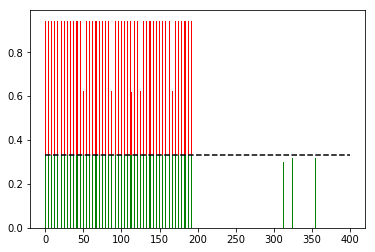

In [31]:
# Remove apkid from integration_results
packer_predict_result = integration_results.drop(['apkid'], axis=1)
# Label the dataframe
packer_predict_result['packer'] = pd.Series("packer", index=packer_predict_result.index)
packer_value_list = packer_predict_result['integrated'].tolist()                                      
integration_n_results2['packer'] = pd.Series("normal", index=integration_n_results2.index)
normal_value_list = integration_n_results2['integrated'].tolist()
all_test = pd.concat([packer_predict_result, integration_n_results2])
all_value_list =  np.array(all_test['integrated'].tolist())
x = range(len(all_value_list))
# BASED ON NORMAL THRESHOLD
threshold = 0.33
above_threshold = np.maximum(all_value_list - threshold, 0)
below_threshold = np.minimum(all_value_list, threshold)
fig, ax = plt.subplots()
ax.bar(x, below_threshold, 0.35, color="g")
ax.bar(x, above_threshold, 0.35, color="r",
        bottom=below_threshold)

# horizontal line indicating the threshold
ax.plot([0., 400], [threshold, threshold], "k--")
plt.savefig(os.path.join(BASE_DIR, 'integrated_normal.pdf'))

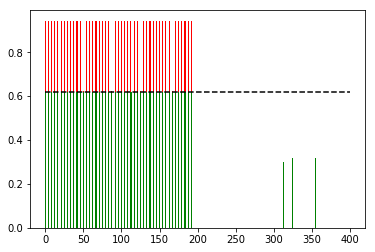

In [36]:
x = range(len(all_value_list))
# BASED ON PACKER THRESHOLD
threshold = 0.6166666666666667
above_threshold = np.maximum(all_value_list - threshold, 0)
below_threshold = np.minimum(all_value_list, threshold)
fig, ax = plt.subplots()
ax.bar(x, below_threshold, 0.35, color="g")
ax.bar(x, above_threshold, 0.35, color="r",
        bottom=below_threshold)

# horizontal line indicating the threshold
ax.plot([0., 400], [threshold, threshold], "k--")
plt.savefig(os.path.join(BASE_DIR, 'integrated_packer.eps'), format='eps', dpi=1000)

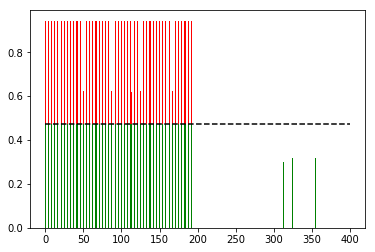

In [33]:
x = range(len(all_value_list))
# BASED ON PACKER THRESHOLD
threshold = (0.6166666666666667 + 0.33) / 2
above_threshold = np.maximum(all_value_list - threshold, 0)
below_threshold = np.minimum(all_value_list, threshold)
fig, ax = plt.subplots()
ax.bar(x, below_threshold, 0.35, color="g")
ax.bar(x, above_threshold, 0.35, color="r",
        bottom=below_threshold)

# horizontal line indicating the threshold
ax.plot([0., 400], [threshold, threshold], "k--")
plt.savefig(os.path.join(BASE_DIR, 'integrated_average.pdf'))

In [82]:
print(integration_n_results2.md5.unique())

['cd8d2363bc952b1f5e36e6dbdd0f3d80']
